# 5th Notebook for Machine Learning Intro Lecture

# 1. introductory kaggle challenge

We will compete in our first [kaggle challenge](https://www.kaggle.com/c/titanic) on the prediction of titanic survivors. 



### Preprocessing and Data check

In [78]:
### Data preprocess

# load and check the data
allTrain = read.csv(file = "data/train_titanic.csv")
str(allTrain)
# no target column "survived" on test dataset
allTest = read.csv(file = "data/test_titanic.csv")

# can we use all features? 
# Nope: delete those with too many levels as this would inflate the model 
# also kill the ID

train = allTrain[, -c(which(colnames(allTrain) == "Cabin"), 
    which(colnames(allTrain) == "Name"), 
    which(colnames(allTrain) == "Ticket"), 
    which(colnames(allTrain) == "PassengerId"))]

test = allTest[, -c(which(colnames(allTest) == "Cabin"), 
    which(colnames(allTest) == "Name"), 
    which(colnames(allTest) == "Ticket"), 
    which(colnames(allTest) == "PassengerId"))]

'data.frame':	891 obs. of  12 variables:
 $ PassengerId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : int  0 1 1 1 0 0 0 0 1 1 ...
 $ Pclass     : int  3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : Factor w/ 891 levels "Abbing, Mr. Anthony",..: 109 191 358 277 16 559 520 629 416 581 ...
 $ Sex        : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ Age        : num  22 38 26 35 35 NA 54 2 27 14 ...
 $ SibSp      : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : Factor w/ 681 levels "110152","110413",..: 525 596 662 50 473 276 86 396 345 133 ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin      : Factor w/ 148 levels "","A10","A14",..: 1 83 1 57 1 1 131 1 1 1 ...
 $ Embarked   : Factor w/ 4 levels "","C","Q","S": 4 2 4 4 4 3 4 4 4 2 ...


### Build a first simple model with mlr and check the performance via CV

In [79]:
### model corner
library(mlr)

# choose specific model and parameters 
task = makeClassifTask(data = train, target = "Survived")

learner = makeLearner(cl = "classif.rpart")
# check choosable parameters and set accordingly
getLearnerParamSet(learner)
# check available settings here: https://www.rdocumentation.org/packages/rpart/versions/4.1-12/topics/rpart.control
learner = makeLearner(cl = "classif.rpart", 
    par.vals = list(minsplit = 10, cp = 0.05))

# make sure to assign mlr package to train
mod = mlr::train(learner = learner, task = task)

### performance estimate via CV
cv = makeResampleDesc(method = "CV", iters = 10)
# use mlr::listMeasures() to get list of possible measures
# important: always check on which measure they evaluate you!
mlr::crossval(learner = learner, task = task, iters = 10, measures = list(mmce, acc))


                   Type len  Def   Constr Req Tunable Trafo
minsplit        integer   -   20 1 to Inf   -    TRUE     -
minbucket       integer   -    - 1 to Inf   -    TRUE     -
cp              numeric   - 0.01   0 to 1   -    TRUE     -
maxcompete      integer   -    4 0 to Inf   -    TRUE     -
maxsurrogate    integer   -    5 0 to Inf   -    TRUE     -
usesurrogate   discrete   -    2    0,1,2   -    TRUE     -
surrogatestyle discrete   -    0      0,1   -    TRUE     -
maxdepth        integer   -   30  1 to 30   -    TRUE     -
xval            integer   -   10 0 to Inf   -   FALSE     -
parms           untyped   -    -        -   -    TRUE     -

[Resample] cross-validation iter 1: mmce.test.mean=0.244,acc.test.mean=0.756
[Resample] cross-validation iter 2: mmce.test.mean=0.169,acc.test.mean=0.831
[Resample] cross-validation iter 3: mmce.test.mean=0.169,acc.test.mean=0.831
[Resample] cross-validation iter 4: mmce.test.mean=0.303,acc.test.mean=0.697
[Resample] cross-validation iter 5: mmce.test.mean=0.225,acc.test.mean=0.775
[Resample] cross-validation iter 6: mmce.test.mean=0.191,acc.test.mean=0.809
[Resample] cross-validation iter 7: mmce.test.mean=0.202,acc.test.mean=0.798
[Resample] cross-validation iter 8: mmce.test.mean=0.191,acc.test.mean=0.809
[Resample] cross-validation iter 9: mmce.test.mean=0.247,acc.test.mean=0.753
[Resample] cross-validation iter 10: mmce.test.mean=0.191,acc.test.mean=0.809
[Resample] Aggr. Result: mmce.test.mean=0.213,acc.test.mean=0.787


Resample Result
Task: train
Learner: classif.rpart
Aggr perf: mmce.test.mean=0.213,acc.test.mean=0.787
Runtime: 0.137429

Store and submit your predictions

In [80]:
# predict for submission
pred = predict(mod, newdata = test)
submission = pred$data

submission$PassengerId = allTest$PassengerId

colnames(submission) = c("Survived", "PassengerId")

write.csv(submission, file = "data/submissionTitanic_1.csv", row.names = FALSE)

### Tune the Hyperparameters of the algorithm

In [81]:
### Tune the model 
# we chose two numeric parameters above and now search for optimal values
# check available parameters
set.seed(1337)
getLearnerParamSet(learner)
# make parameter set
paramSet = makeParamSet(
    makeDiscreteParam("minsplit", values = c(1, 3, 5, 7, 10, 15, 20, 30, 40, 45, 50, 60, 70, 100)), 
    makeNumericParam("cp", lower = 0.0001, upper = 0.1)
)
# choose random search - why not grid search?
ctrl = makeTuneControlRandom(maxit = 100)
resDesc = makeResampleDesc("CV", iters = 10L, predict = "both")
tunes = mlr::tuneParams(learner = learner, task = task, resampling = resDesc,
    par.set = paramSet, control = ctrl, measures = list(mmce, acc))

                   Type len  Def   Constr Req Tunable Trafo
minsplit        integer   -   20 1 to Inf   -    TRUE     -
minbucket       integer   -    - 1 to Inf   -    TRUE     -
cp              numeric   - 0.01   0 to 1   -    TRUE     -
maxcompete      integer   -    4 0 to Inf   -    TRUE     -
maxsurrogate    integer   -    5 0 to Inf   -    TRUE     -
usesurrogate   discrete   -    2    0,1,2   -    TRUE     -
surrogatestyle discrete   -    0      0,1   -    TRUE     -
maxdepth        integer   -   30  1 to 30   -    TRUE     -
xval            integer   -   10 0 to Inf   -   FALSE     -
parms           untyped   -    -        -   -    TRUE     -

[Tune] Started tuning learner classif.rpart for parameter set:
             Type len Def                                 Constr Req Tunable
minsplit discrete   -   - 1,3,5,7,10,15,20,30,40,45,50,60,70,100   -    TRUE
cp        numeric   -   -                          0.0001 to 0.1   -    TRUE
         Trafo
minsplit     -
cp           -
With control class: TuneControlRandom
Imputation value: 1Imputation value: -0
[Tune-x] 1: minsplit=20; cp=0.0317
[Tune-y] 1: mmce.test.mean=0.211,acc.test.mean=0.789; time: 0.0 min
[Tune-x] 2: minsplit=10; cp=0.0149
[Tune-y] 2: mmce.test.mean=0.196,acc.test.mean=0.804; time: 0.0 min
[Tune-x] 3: minsplit=50; cp=0.0618
[Tune-y] 3: mmce.test.mean=0.213,acc.test.mean=0.787; time: 0.0 min
[Tune-x] 4: minsplit=10; cp=0.0954
[Tune-y] 4: mmce.test.mean=0.213,acc.test.mean=0.787; time: 0.0 min
[Tune-x] 5: minsplit=3; cp=0.0335
[Tune-y] 5: mmce.test.mean=0.213,acc.test.mean=0.787; time: 0.0 min
[Tune-x] 6: minsplit=7; cp=0.0723
[Tune-y] 6: mmce.test.mean=0.213,ac

[Tune-x] 76: minsplit=40; cp=0.0922
[Tune-y] 76: mmce.test.mean=0.213,acc.test.mean=0.787; time: 0.0 min
[Tune-x] 77: minsplit=100; cp=0.0698
[Tune-y] 77: mmce.test.mean=0.213,acc.test.mean=0.787; time: 0.0 min
[Tune-x] 78: minsplit=30; cp=0.037
[Tune-y] 78: mmce.test.mean=0.213,acc.test.mean=0.787; time: 0.0 min
[Tune-x] 79: minsplit=3; cp=0.0347
[Tune-y] 79: mmce.test.mean=0.213,acc.test.mean=0.787; time: 0.0 min
[Tune-x] 80: minsplit=70; cp=0.0964
[Tune-y] 80: mmce.test.mean=0.213,acc.test.mean=0.787; time: 0.0 min
[Tune-x] 81: minsplit=40; cp=0.0346
[Tune-y] 81: mmce.test.mean=0.213,acc.test.mean=0.787; time: 0.0 min
[Tune-x] 82: minsplit=1; cp=0.059
[Tune-y] 82: mmce.test.mean=0.213,acc.test.mean=0.787; time: 0.0 min
[Tune-x] 83: minsplit=30; cp=0.0936
[Tune-y] 83: mmce.test.mean=0.213,acc.test.mean=0.787; time: 0.0 min
[Tune-x] 84: minsplit=50; cp=0.081
[Tune-y] 84: mmce.test.mean=0.213,acc.test.mean=0.787; time: 0.0 min
[Tune-x] 85: minsplit=45; cp=0.0191
[Tune-y] 85: mmce.test.

Visualize the random search over both parameters:

Tune result:
Op. pars: minsplit=10; cp=0.00923
mmce.test.mean=0.189,acc.test.mean=0.811

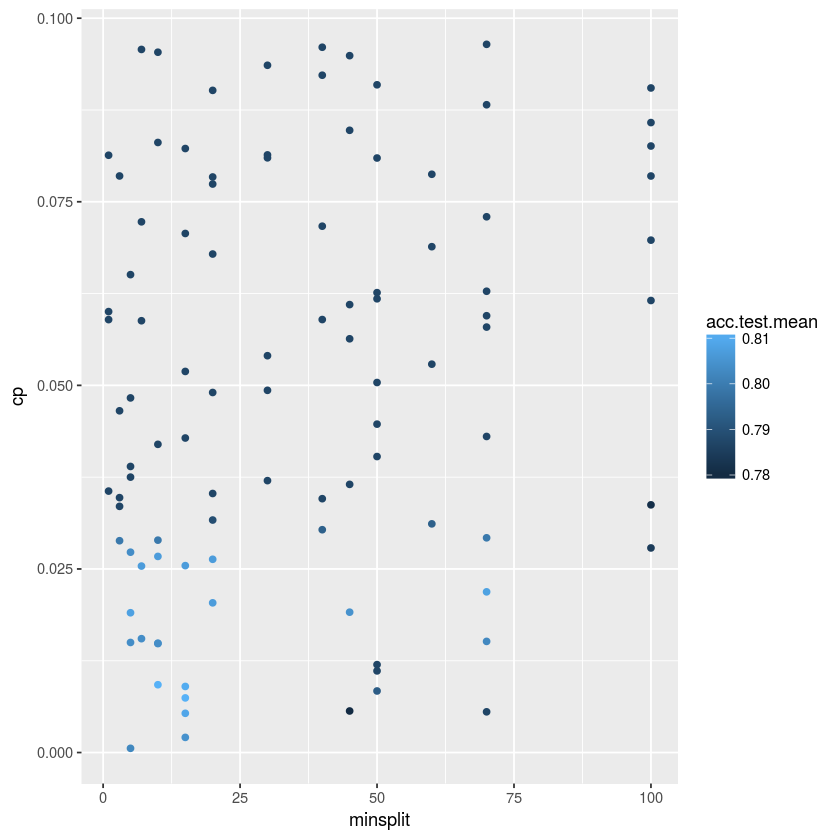

In [82]:
visHyper = generateHyperParsEffectData(tunes)
plt = plotHyperParsEffect(visHyper, x = "minsplit", y = "cp", z = "acc.test.mean")
plt
# tuning result
tunes

Store and submit those results to kaggle

In [83]:
# use those param settings for the CART
learner = makeLearner(cl = "classif.rpart", 
    par.vals = list(minsplit = 10, cp = 0.0923))# inspect the learner
# learner
mod = mlr::train(learner = learner, task = task)

# predict for submission
pred = predict(mod, newdata = test)
submission = pred$data

submission$PassengerId = allTest$PassengerId

colnames(submission) = c("Survived", "PassengerId")

write.csv(submission, file = "data/submissionTitanic_2.csv", row.names = FALSE)

#### Check variable importances

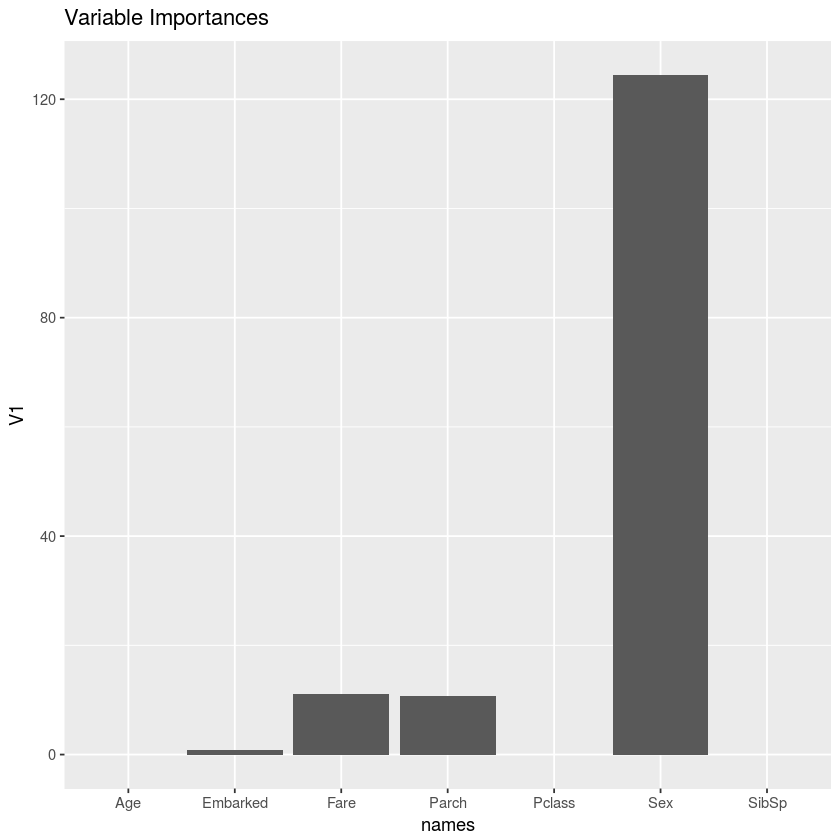

In [84]:
library(ggplot2)
varimp = getFeatureImportance(mod)
var = as.data.frame(t(varimp$res))
var$names = names(varimp$res)
p = ggplot(data = var, aes(x = names, y = V1)) + geom_bar(stat = "identity") +
    ggtitle(label = "Variable Importances")
p

### Feature engineering

Can we further condense the information from the multi-level factors and use it for our model?

We take a closer look at the names of the guests. 


In [85]:

### feature engineering
library(dplyr)

# indicator for train or test set
allTrain$train = 1
allTest$train = 0
allTest$Survived = NA

# compute once for all data and split again for training with ID
allData = rbind(allTrain, allTest)
engData = allData

head(allData$Name)


[1] Braund, Mr. Owen Harris                            
[2] Cumings, Mrs. John Bradley (Florence Briggs Thayer)
[3] Heikkinen, Miss. Laina                             
[4] Futrelle, Mrs. Jacques Heath (Lily May Peel)       
[5] Allen, Mr. William Henry                           
[6] Moran, Mr. James                                   
1307 Levels: Abbing, Mr. Anthony ... Zakarian, Mr. Ortin

We can see, that there is information on the title of the people in their names. We use that information as a new feature!

In [86]:
# use regular expressions via strplit to extract the title of the people
# temporary storage
temp = sapply(strsplit(as.character(allData$Name), split = ","), function(x) x[2])
title = strsplit(temp, split = " ")
engData$title = sapply(title, function(x) x[2])
# unfortunately still too many titles with too less observations
table(engData$title)


    Capt.      Col.      Don.     Dona.       Dr. Jonkheer.     Lady.    Major. 
        1         4         1         1         8         1         1         2 
  Master.     Miss.     Mlle.      Mme.       Mr.      Mrs.       Ms.      Rev. 
       61       260         2         1       757       197         2         8 
     Sir.       the 
        1         1 

Btw.: we found the Captain:

In [87]:
# btw.: we found the captain:
allData[which(engData$title == "Capt."), "Name"]

[1] Crosby, Capt. Edward Gifford
1307 Levels: Abbing, Mr. Anthony ... Zakarian, Mr. Ortin

condense those with obs < 5 to class "other"

In [88]:
freqs = as.data.frame(table(engData$title))
otherTitles = freqs[which(freqs$Freq < 5), "Var1"]
engData[which(engData$title %in% otherTitles), "title"] = "other"
engData$title = as.factor(engData$title)
# looks better now
table(engData$title)


    Dr. Master.   Miss.     Mr.    Mrs.   other    Rev. 
      8      61     260     757     197      18       8 

### Build updated model

In [89]:
### model corner 2 with engineered feature
library(mlr)
library(dplyr)

train = engData %>% 
    filter(train == 1) %>%
    select(-c(PassengerId, Name, Ticket, train, Cabin))

test = engData %>% 
    filter(train == 0) %>%
    select(-c(PassengerId, Name, Ticket, train, Cabin, Survived))

# choose specific model and parameters 
task = makeClassifTask(data = train, target = "Survived")

learner = makeLearner(cl = "classif.rpart")
# we chose two numeric parameters above and now search for optimal values
paramSet = makeParamSet(
    makeDiscreteParam("minsplit", values = c(1, 3, 5, 7, 10, 15, 20, 30, 40, 45, 50, 60, 70, 100)), 
    makeNumericParam("cp", lower = 0.0001, upper = 0.1)
)
# choose random search - why not grid search?
ctrl = makeTuneControlRandom(maxit = 100)
resDesc = makeResampleDesc("CV", iters = 10L, predict = "both")
tunes = mlr::tuneParams(learner = learner, task = task, resampling = resDesc,
    par.set = paramSet, control = ctrl, measures = list(mmce, acc))


[Tune] Started tuning learner classif.rpart for parameter set:
             Type len Def                                 Constr Req Tunable
minsplit discrete   -   - 1,3,5,7,10,15,20,30,40,45,50,60,70,100   -    TRUE
cp        numeric   -   -                          0.0001 to 0.1   -    TRUE
         Trafo
minsplit     -
cp           -
With control class: TuneControlRandom
Imputation value: 1Imputation value: -0
[Tune-x] 1: minsplit=45; cp=0.0231
[Tune-y] 1: mmce.test.mean=0.175,acc.test.mean=0.825; time: 0.0 min
[Tune-x] 2: minsplit=7; cp=0.0995
[Tune-y] 2: mmce.test.mean=0.212,acc.test.mean=0.788; time: 0.0 min
[Tune-x] 3: minsplit=40; cp=0.0725
[Tune-y] 3: mmce.test.mean=0.212,acc.test.mean=0.788; time: 0.0 min
[Tune-x] 4: minsplit=70; cp=0.00889
[Tune-y] 4: mmce.test.mean=0.184,acc.test.mean=0.816; time: 0.0 min
[Tune-x] 5: minsplit=7; cp=0.0449
[Tune-y] 5: mmce.test.mean=0.175,acc.test.mean=0.825; time: 0.0 min
[Tune-x] 6: minsplit=50; cp=0.06
[Tune-y] 6: mmce.test.mean=0.212,acc

[Tune-x] 76: minsplit=30; cp=0.0493
[Tune-y] 76: mmce.test.mean=0.184,acc.test.mean=0.816; time: 0.0 min
[Tune-x] 77: minsplit=5; cp=0.0811
[Tune-y] 77: mmce.test.mean=0.212,acc.test.mean=0.788; time: 0.0 min
[Tune-x] 78: minsplit=7; cp=0.0371
[Tune-y] 78: mmce.test.mean=0.175,acc.test.mean=0.825; time: 0.0 min
[Tune-x] 79: minsplit=70; cp=0.0894
[Tune-y] 79: mmce.test.mean=0.212,acc.test.mean=0.788; time: 0.0 min
[Tune-x] 80: minsplit=60; cp=0.0701
[Tune-y] 80: mmce.test.mean=0.212,acc.test.mean=0.788; time: 0.0 min
[Tune-x] 81: minsplit=1; cp=0.0247
[Tune-y] 81: mmce.test.mean=0.175,acc.test.mean=0.825; time: 0.0 min
[Tune-x] 82: minsplit=15; cp=0.0116
[Tune-y] 82: mmce.test.mean=0.176,acc.test.mean=0.824; time: 0.0 min
[Tune-x] 83: minsplit=60; cp=0.0479
[Tune-y] 83: mmce.test.mean=0.184,acc.test.mean=0.816; time: 0.0 min
[Tune-x] 84: minsplit=5; cp=0.0623
[Tune-y] 84: mmce.test.mean=0.212,acc.test.mean=0.788; time: 0.0 min
[Tune-x] 85: minsplit=30; cp=0.0867
[Tune-y] 85: mmce.test.

Check tuning result

In [90]:
tunes

Tune result:
Op. pars: minsplit=40; cp=0.00601
mmce.test.mean=0.169,acc.test.mean=0.831

Write and store the submission

In [91]:
# use those param settings for the CART
learner = makeLearner(cl = "classif.rpart", 
    par.vals = list(minsplit = 7, cp = 0.00601))

mod = mlr::train(learner = learner, task = task)

# predict for submission
pred = predict(mod, newdata = test)
submission = pred$data

submission$PassengerId = engData %>% 
    filter(train == 0) %>%
    select(PassengerId)

colnames(submission) = c("Survived", "PassengerId")

write.csv(submission, file = "data/submissionTitanic_3.csv", row.names = FALSE)

#### Check Variable Importances

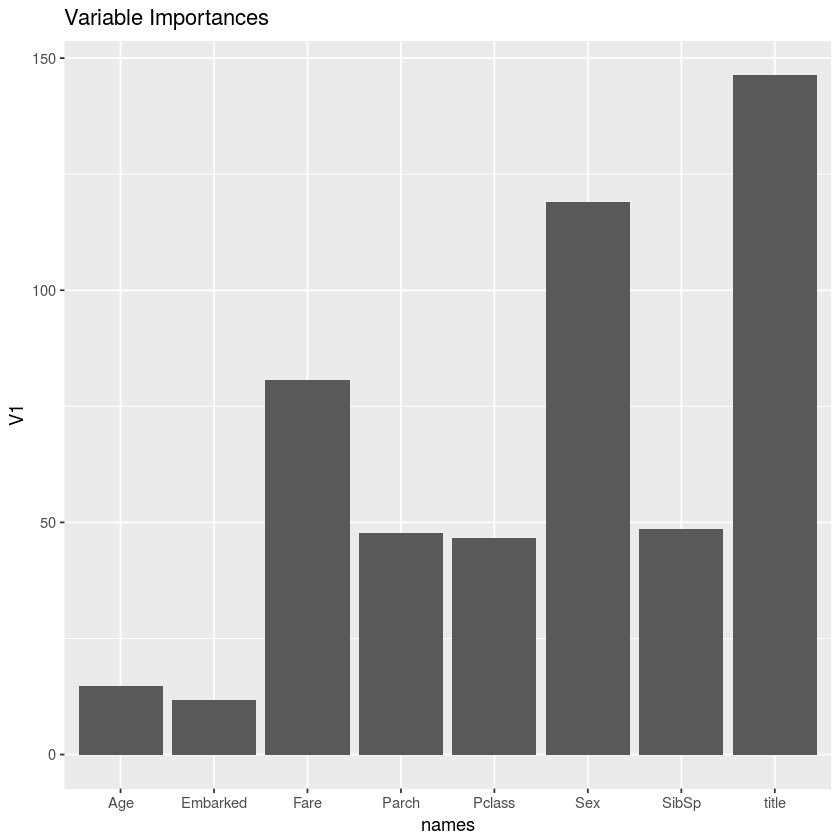

In [92]:
library(ggplot2)
varimp = getFeatureImportance(mod)
var = as.data.frame(t(varimp$res))
var$names = names(varimp$res)
p = ggplot(data = var, aes(x = names, y = V1)) + geom_bar(stat = "identity") +
    ggtitle(label = "Variable Importances")
p

What can we see? How could we critisize that result? Is there a way to detect the problem?